In [1]:
# from time import sleep
# sleep(4000)

In [2]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import stable_baselines3 as sb3
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
import stable_baselines3.common.logger as logger

from tqdm import tqdm, trange

import flygym.util.vision as vision
from flygym.envs.nmf_mujoco import MuJoCoParameters

import numpy as np
import gymnasium as gym
from typing import Tuple
from dm_control import mjcf
from dm_control.rl.control import PhysicsError

import flygym.util.vision as vision
import flygym.util.config as config
from flygym.arena import BaseArena
from flygym.envs.nmf_mujoco import MuJoCoParameters

from cpg_controller import NMFCPG

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:4: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, "__version__") or LooseVersion(
/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  ) < LooseVersion("1.15"):


In [3]:
class MovingObjArena(BaseArena):
    """Flat terrain with a hovering moving object.

    Attributes
    ----------
    arena : mjcf.RootElement
        The arena object that the terrain is built on.
    ball_pos : Tuple[float,float,float]
        The position of the floating object in the arena.

    Parameters
    ----------
    size : Tuple[int, int]
        The size of the terrain in (x, y) dimensions.
    friction : Tuple[float, float, float]
        Sliding, torsional, and rolling friction coefficients, by default
        (1, 0.005, 0.0001)
    obj_radius : float
        Radius of the spherical floating object in mm.
    obj_spawn_pos : Tuple[float,float,float]
        Initial position of the object, by default (0, 2, 1).
    move_mode : string
        Type of movement performed by the floating object.
        Can be "random" (default value), "straightHeading", "circling" or "s_shape".
    move_speed : float
        Speed of the moving object. Angular velocity if move_mode=="circling" or "s_shape".
    """

    def __init__(
        self,
        size: Tuple[float, float] = (200, 200),
        friction: Tuple[float, float, float] = (1, 0.005, 0.0001),
        obj_radius: float = 2,
        obj_spawn_pos: Tuple[float, float, float] = (0, 2, 0),
        move_mode: str = "random",
        move_speed: float = 25,
    ):
        self.root_element = mjcf.RootElement()
        ground_size = [*size, 1]
        chequered = self.root_element.asset.add(
            "texture",
            type="2d",
            builtin="checker",
            width=300,
            height=300,
            rgb1=(0.4, 0.4, 0.4),
            rgb2=(0.5, 0.5, 0.5),
        )
        grid = self.root_element.asset.add(
            "material",
            name="grid",
            texture=chequered,
            texrepeat=(10, 10),
            reflectance=0.1,
        )
        self.root_element.worldbody.add(
            "geom",
            type="plane",
            name="ground",
            material=grid,
            size=ground_size,
            friction=friction,
        )
        self.root_element.worldbody.add("body", name="b_plane")
        # Add ball
        obstacle = self.root_element.asset.add(
            "material", name="obstacle", reflectance=0.1
        )
        self.root_element.worldbody.add(
            "body", name="ball_mocap", mocap=True, pos=obj_spawn_pos, gravcomp=1
        )
        self.object_body = self.root_element.find("body", "ball_mocap")
        self.object_body.add(
            "geom",
            name="ball",
            type="sphere",
            size=(obj_radius, obj_radius),
            rgba=(0.0, 0.0, 0.0, 1),
            material=obstacle,
        )
        self.friction = friction
        self.move_mode = move_mode
        self.move_speed = move_speed

        if move_mode == "circling":
            circumference = 2 * np.pi * 15
            period = circumference / move_speed
            self.pos_func = lambda t: np.array(
                [
                    15 * np.cos(2 * np.pi * (t / period)),
                    15 * np.sin(2 * np.pi * (t / period)),
                    obj_radius,
                ]
            )
            self.init_ball_pos = self.pos_func(0)
            self.ball_pos = self.init_ball_pos
        elif move_mode == "s_shape":
            self.pos_func = lambda t: np.array(
                [
                    move_speed * t + obj_spawn_pos[0],
                    0.15 * move_speed * np.sin(t * 3) + obj_spawn_pos[1],
                    obj_radius,
                ]
            )
            self.init_ball_pos = (obj_spawn_pos[0], obj_spawn_pos[1], obj_radius)
            self.ball_pos = self.init_ball_pos
        else:
            raise NotImplementedError

        if move_speed == -1:
            base_speed = 0.003
            if self.move_mode == "straightHeading":
                self.move_speed = base_speed
            elif self.move_mode == "circling" or self.move_mode == "s_shape":
                self.move_speed = base_speed / self.radius
        else:
            self.move_speed = move_speed

        self.root_element.worldbody.add(
            "camera",
            name="birdseye_cam",
            mode="fixed",
            pos=(0, 0, 50),
            euler=(0, 0, 0),
            fovy=40,
        )

        self.curr_time = 0
        self._obj_pos_history_li = [[self.curr_time, *self.ball_pos]]

    def get_spawn_position(
        self, rel_pos: np.ndarray, rel_angle: np.ndarray
    ) -> Tuple[np.ndarray, np.ndarray]:
        return rel_pos, rel_angle

    def step(self, dt, physics):
        self.ball_pos = self.pos_func(self.curr_time)

        physics.bind(self.object_body).mocap_pos = self.ball_pos

        self.curr_time += dt
        self._obj_pos_history_li.append([self.curr_time, *self.ball_pos])

    def reset(self, physics):
        self.curr_time = 0
        self.ball_pos = self.init_ball_pos
        physics.bind(self.object_body).mocap_pos = self.ball_pos
        self._obj_pos_history_li = [[self.curr_time, *self.ball_pos]]

    @property
    def obj_pos_history(self):
        return np.array(self._obj_pos_history_li)


class NMFVisualTaxis(NMFCPG):
    def __init__(
        self,
        decision_dt=0.05,
        n_stabilisation_steps: int = 5000,
        obj_threshold=50,
        max_time=2,
        **kwargs
    ) -> None:
        if "sim_params" in kwargs:
            sim_params = kwargs["sim_params"]
            del kwargs["sim_params"]
        else:
            sim_params = MuJoCoParameters()
        sim_params.enable_vision = True
        sim_params.vision_refresh_rate = int(1 / decision_dt)
        self.max_time = max_time

        super().__init__(
            sim_params=sim_params,
            n_oscillators=6,
            n_stabilisation_steps=n_stabilisation_steps,
            **kwargs
        )
        self.decision_dt = decision_dt
        self.obj_threshold = obj_threshold
        self.num_substeps = int(decision_dt / self.timestep)

        # Override spaces
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(2,))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(6,))

        # Compute x-y position of each ommatidium
        self.coms = np.empty((config.num_ommatidia_per_eye, 2))
        for i in range(config.num_ommatidia_per_eye):
            mask = vision.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)

        self._last_offset_from_ideal = self._calc_offset_from_ideal(
            np.zeros(2), self.arena.ball_pos[:2]
        )

    @staticmethod
    def _calc_offset_from_ideal(fly_pos, obj_pos):
        fly_obj_distance = np.linalg.norm(fly_pos - obj_pos)
        return np.abs(fly_obj_distance - 5)

    def step(self, amplitude):
        try:
            for i in range(self.num_substeps):
                raw_obs, _, raw_term, raw_trunc, info = super().step(amplitude)
                super().render()
        except PhysicsError:
            print("Physics error, resetting environment")
            return np.zeros((6,), dtype="float32"), 0, False, True, {}

        assert abs(self.curr_time - self._last_vision_update_time) < 0.5 * self.timestep
        obs = self._get_visual_features().astype("float32")

        # calculate reward
        fly_pos = super().get_observation()["fly"][0, :2]
        curr_offset_from_ideal = self._calc_offset_from_ideal(
            fly_pos, self.arena.ball_pos[:2]
        )
        fly_obj_distance = np.linalg.norm(fly_pos - self.arena.ball_pos[:2])
        unadjusted_reward = self._last_offset_from_ideal - curr_offset_from_ideal
        if curr_offset_from_ideal > 15:  # too far from object, fail
            reward = -15
            terminated = True
            info["state_desc"] = "too far from object"
        elif obs[2] + obs[5] < 0.005:  # lost object from both eyes, fail
            reward = -10
            terminated = True
            info["state_desc"] = "object lost visually"
        elif curr_offset_from_ideal < 1:  # this is perfect, reward regardless of change
            reward = 3
            terminated = False
            info["state_desc"] = "ideal range"
        elif fly_obj_distance < 3:  # collision/too close, fail
            reward = -5
            terminated = True
            info["state_desc"] = "collision"
        else:  # reward is improvement from last step
            reward = unadjusted_reward
            terminated = False
            info["state_desc"] = "seeking"
        info["unadjusted reward"] = unadjusted_reward
        info["offset_from_ideal"] = curr_offset_from_ideal
        truncated = self.curr_time > 1 and not terminated  # start a new episode
        self._last_offset_from_ideal = curr_offset_from_ideal

        return obs, reward, terminated, truncated, info

    def reset(self):
        super().reset()
        self.arena.reset(self.physics)
        obs = self._get_visual_features().astype("float32")
        return obs, {}

    def _get_visual_features(self):
        raw_obs = super().get_observation()
        # features = np.full((2, 3), np.nan)  # ({L, R}, {y_center, x_center, area})
        features = np.zeros((2, 3))
        for i, ommatidia_readings in enumerate(raw_obs["vision"]):
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj[
                np.arange(is_obj.size) % 2 == 1
            ] = False  # only use pale-type ommatidia
            is_obj_coords = self.coms[is_obj]
            if is_obj_coords.shape[0] > 0:
                features[i, :2] = is_obj_coords.mean(axis=0)
            features[i, 2] = is_obj_coords.shape[0]
        features[:, 0] /= config.raw_img_height_px  # normalize y_center
        features[:, 1] /= config.raw_img_width_px  # normalize x_center
        # features[:, :2] = features[:, :2] * 2 - 1  # center around 0
        features[:, 2] /= config.num_ommatidia_per_eye  # normalize area
        return features.flatten()

    def _calc_delta_dist(self, fly_pos, obj_pos):
        dist_from_obj = np.linalg.norm(fly_pos - obj_pos)
        if self._last_offset_from_ideal is not None:
            delta_dist = self._last_offset_from_ideal - dist_from_obj
        else:
            delta_dist = 0
        self._last_offset_from_ideal = dist_from_obj
        return delta_dist

In [4]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

In [5]:
arena = MovingObjArena(obj_spawn_pos=(5, 3, 0), move_mode="circling", move_speed=30)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
sim = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
    spawn_orient=(0, 0, 1, np.pi / 2),
    spawn_pos=(15, -10, 0.5),
)


In [6]:
obs, info = sim.reset()

for i in range(10):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    print(reward, terminated, truncated, info)

sim.reset()

obs_hist = [obs]
visual_hist = [sim.curr_visual_input]
ball_pos_hist = []
for i in range(20):
    obs, reward, terminated, truncated, info = sim.step(np.array([0.5, 0.5]))
    obs_hist.append(obs)
    ball_pos_hist.append(sim.arena.ball_pos[:2])
    if i < 9:
        visual_hist.append(sim.curr_visual_input)
    print(reward, terminated, truncated, info)

sim.save_video("visual_taxis_test4.mp4")

/home/sibwang/anaconda3/envs/flygym/lib/python3.8/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


4.5773613449564365 False False {'state_desc': 'seeking', 'unadjusted reward': 4.5773613449564365, 'offset_from_ideal': 5.4226386550435635}
0.39176087310513985 False False {'state_desc': 'seeking', 'unadjusted reward': 0.39176087310513985, 'offset_from_ideal': 5.030877781938424}
0.30245833339493267 False False {'state_desc': 'seeking', 'unadjusted reward': 0.30245833339493267, 'offset_from_ideal': 4.728419448543491}
0.4026936865975177 False False {'state_desc': 'seeking', 'unadjusted reward': 0.4026936865975177, 'offset_from_ideal': 4.325725761945973}
0.35891344069012554 False False {'state_desc': 'seeking', 'unadjusted reward': 0.35891344069012554, 'offset_from_ideal': 3.9668123212558477}
0.3420312720333669 False False {'state_desc': 'seeking', 'unadjusted reward': 0.3420312720333669, 'offset_from_ideal': 3.624781049222481}
0.40805268996329325 False False {'state_desc': 'seeking', 'unadjusted reward': 0.40805268996329325, 'offset_from_ideal': 3.2167283592591875}
0.35751143688538534 Fal

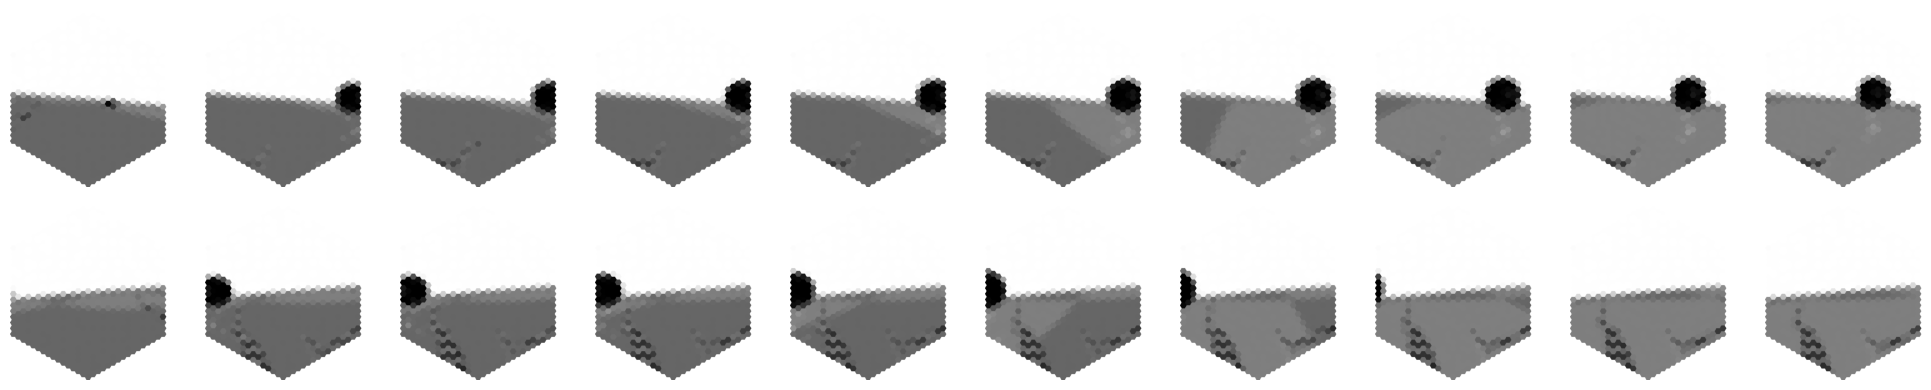

In [7]:
fig, axs = plt.subplots(2, 10, figsize=(20, 4), tight_layout=True)
for i, visual_obs in enumerate(visual_hist):
    human_readable_img_left = vision.hex_pxls_to_human_readable(visual_obs[0], vision.ommatidia_id_map)
    axs[0, i].imshow(human_readable_img_left, cmap="gray", vmin=0, vmax=255)
    axs[0, i].axis("off")
    human_readable_img_right = vision.hex_pxls_to_human_readable(visual_obs[1], vision.ommatidia_id_map)
    axs[1, i].imshow(human_readable_img_right, cmap="gray", vmin=0, vmax=255)
    axs[1, i].axis("off")

(-0.01, 0.3)

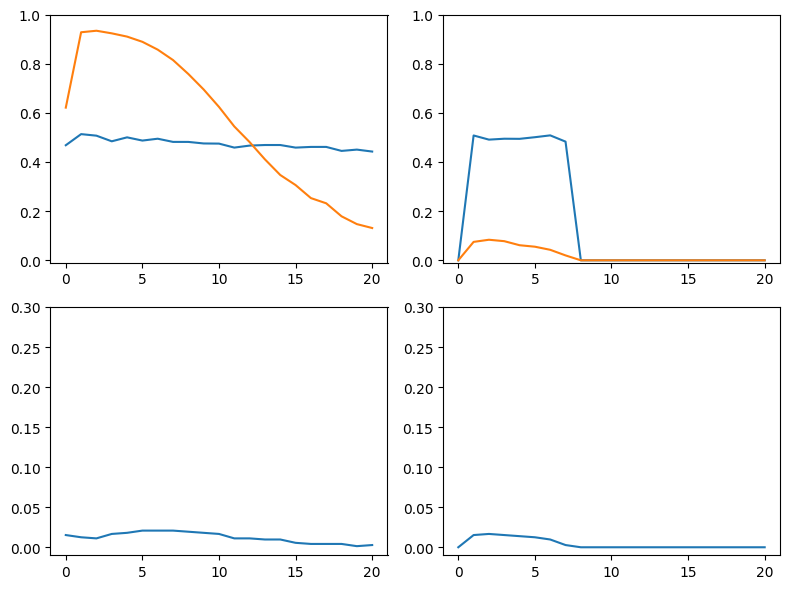

In [8]:
obs_hist = np.array(obs_hist)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), tight_layout=True)
axs[0, 0].plot(obs_hist[:, 0])
axs[0, 0].plot(obs_hist[:, 1])
axs[0, 0].set_ylim(-0.01, 1)
axs[1, 0].plot(obs_hist[:, 2])
axs[1, 0].set_ylim(-0.01, 0.3)

axs[0, 1].plot(obs_hist[:, 3])
axs[0, 1].plot(obs_hist[:, 4])
axs[0, 1].set_ylim(-0.01, 1)
axs[1, 1].plot(obs_hist[:, 5])
axs[1, 1].set_ylim(-0.01, 0.3)

In [9]:
arena = MovingObjArena(obj_spawn_pos=(5, 3, 0), move_mode="s_shape", move_speed=30)
sim_params = MuJoCoParameters(render_playspeed=0.2, render_camera="Animat/camera_top_zoomout", vision_refresh_rate=25)
task = NMFVisualTaxis(
    sim_params=sim_params,
    arena=arena,
    decision_dt=0.05,
    n_stabilisation_steps=5000,
    obj_threshold=50,
)
check_env(task)

In [10]:
np.random.seed(0)
sb3.common.utils.set_random_seed(0, using_cuda=True)

log_dir = "logs/object_tracking_sac4"
checkpoint_callback = CheckpointCallback(
  save_freq=1000,
  save_path=log_dir,
  name_prefix="object_tracking_sac4",
  save_replay_buffer=True,
  save_vecnormalize=True,
)
my_logger = logger.configure(log_dir, ["tensorboard", "stdout", "csv"])
model = sb3.SAC("MlpPolicy", env=task, policy_kwargs={"net_arch": [16, 16]}, verbose=2, learning_rate=0.01)
model.set_logger(my_logger)

model.learn(total_timesteps=25_000, progress_bar=True, callback=checkpoint_callback)

model.save("models/object_tracking_sac4")

Logging to logs/object_tracking_sac4
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | -8.06    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 1        |
|    time_elapsed    | 47       |
|    total_timesteps | 53       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 12.2     |
|    ep_rew_mean     | -8.86    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 1        |
|    time_elapsed    | 87       |
|    total_timesteps | 98       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 13.2     |
|    ep_rew_mean     | -7.76    |
| time/              |          |
|    episodes        | 12       |
|    fps             | 1        |
|    time_elapsed    | 142      |
|    total_timesteps | 158      |
| train/             |          |
|    actor_loss      | -0.83    |
|    critic_loss     | 8        |
|    ent_coef        | 0.572    |
|    ent_coef_loss   | -1.8     |
|    learning_rate   | 0.01     |
|    n_updates       | 57       |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 14.4     |
|    ep_rew_mean     | -4.96    |
| time/              |          |
|    episodes        | 16       |
|    fps             | 1        |
|    time_elapsed    | 206      |
|    total_timesteps | 231      |
| train/             |          |
|    actor_loss      | 0.0502   |
|    critic_loss     | 4.18     |
|    ent_coef        | 0.293    |
|    ent_coef_loss   | -3.17    |
|    learning_rate   | 0.01     |
|    n_updates       | 130      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15.6     |
|    ep_rew_mean     | -1.92    |
| time/              |          |
|    episodes        | 20       |
|    fps             | 1        |
|    time_elapsed    | 275      |
|    total_timesteps | 311      |
| train/             |          |
|    actor_loss      | -0.308   |
|    critic_loss     | 2.92     |
|    ent_coef        | 0.159    |
|    ent_coef_loss   | -2.43    |
|    learning_rate   | 0.01     |
|    n_updates       | 210      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16       |
|    ep_rew_mean     | 1.75     |
| time/              |          |
|    episodes        | 24       |
|    fps             | 1        |
|    time_elapsed    | 339      |
|    total_timesteps | 385      |
| train/             |          |
|    actor_loss      | -1.03    |
|    critic_loss     | 4.8      |
|    ent_coef        | 0.11     |
|    ent_coef_loss   | -0.434   |
|    learning_rate   | 0.01     |
|    n_updates       | 284      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.6     |
|    ep_rew_mean     | 5.43     |
| time/              |          |
|    episodes        | 28       |
|    fps             | 1        |
|    time_elapsed    | 409      |
|    total_timesteps | 466      |
| train/             |          |
|    actor_loss      | -1.28    |
|    critic_loss     | 4.47     |
|    ent_coef        | 0.108    |
|    ent_coef_loss   | -0.00198 |
|    learning_rate   | 0.01     |
|    n_updates       | 365      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 16.8     |
|    ep_rew_mean     | 7.25     |
| time/              |          |
|    episodes        | 32       |
|    fps             | 1        |
|    time_elapsed    | 471      |
|    total_timesteps | 538      |
| train/             |          |
|    actor_loss      | -1.76    |
|    critic_loss     | 3.56     |
|    ent_coef        | 0.103    |
|    ent_coef_loss   | 0.642    |
|    learning_rate   | 0.01     |
|    n_updates       | 437      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.3     |
|    ep_rew_mean     | 9.54     |
| time/              |          |
|    episodes        | 36       |
|    fps             | 1        |
|    time_elapsed    | 543      |
|    total_timesteps | 622      |
| train/             |          |
|    actor_loss      | -1.87    |
|    critic_loss     | 3.75     |
|    ent_coef        | 0.105    |
|    ent_coef_loss   | 0.241    |
|    learning_rate   | 0.01     |
|    n_updates       | 521      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 17.6     |
|    ep_rew_mean     | 11.4     |
| time/              |          |
|    episodes        | 40       |
|    fps             | 1        |
|    time_elapsed    | 617      |
|    total_timesteps | 706      |
| train/             |          |
|    actor_loss      | -2.4     |
|    critic_loss     | 4.83     |
|    ent_coef        | 0.103    |
|    ent_coef_loss   | -0.079   |
|    learning_rate   | 0.01     |
|    n_updates       | 605      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18       |
|    ep_rew_mean     | 13       |
| time/              |          |
|    episodes        | 44       |
|    fps             | 1        |
|    time_elapsed    | 691      |
|    total_timesteps | 790      |
| train/             |          |
|    actor_loss      | -2.63    |
|    critic_loss     | 3.7      |
|    ent_coef        | 0.101    |
|    ent_coef_loss   | -0.245   |
|    learning_rate   | 0.01     |
|    n_updates       | 689      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.2     |
|    ep_rew_mean     | 15       |
| time/              |          |
|    episodes        | 48       |
|    fps             | 1        |
|    time_elapsed    | 764      |
|    total_timesteps | 874      |
| train/             |          |
|    actor_loss      | -2.76    |
|    critic_loss     | 2.63     |
|    ent_coef        | 0.108    |
|    ent_coef_loss   | 0.0725   |
|    learning_rate   | 0.01     |
|    n_updates       | 773      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.4     |
|    ep_rew_mean     | 16.3     |
| time/              |          |
|    episodes        | 52       |
|    fps             | 1        |
|    time_elapsed    | 838      |
|    total_timesteps | 958      |
| train/             |          |
|    actor_loss      | -2.66    |
|    critic_loss     | 3.53     |
|    ent_coef        | 0.112    |
|    ent_coef_loss   | -0.0837  |
|    learning_rate   | 0.01     |
|    n_updates       | 857      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.6     |
|    ep_rew_mean     | 17.9     |
| time/              |          |
|    episodes        | 56       |
|    fps             | 1        |
|    time_elapsed    | 911      |
|    total_timesteps | 1042     |
| train/             |          |
|    actor_loss      | -2.95    |
|    critic_loss     | 3.18     |
|    ent_coef        | 0.113    |
|    ent_coef_loss   | 0.484    |
|    learning_rate   | 0.01     |
|    n_updates       | 941      |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.8     |
|    ep_rew_mean     | 19.8     |
| time/              |          |
|    episodes        | 60       |
|    fps             | 1        |
|    time_elapsed    | 984      |
|    total_timesteps | 1126     |
| train/             |          |
|    actor_loss      | -3.94    |
|    critic_loss     | 4.52     |
|    ent_coef        | 0.11     |
|    ent_coef_loss   | 0.187    |
|    learning_rate   | 0.01     |
|    n_updates       | 1025     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | 21.2     |
| time/              |          |
|    episodes        | 64       |
|    fps             | 1        |
|    time_elapsed    | 1058     |
|    total_timesteps | 1210     |
| train/             |          |
|    actor_loss      | -4.72    |
|    critic_loss     | 3.27     |
|    ent_coef        | 0.119    |
|    ent_coef_loss   | -0.488   |
|    learning_rate   | 0.01     |
|    n_updates       | 1109     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19       |
|    ep_rew_mean     | 22.7     |
| time/              |          |
|    episodes        | 68       |
|    fps             | 1        |
|    time_elapsed    | 1130     |
|    total_timesteps | 1294     |
| train/             |          |
|    actor_loss      | -5.1     |
|    critic_loss     | 3.31     |
|    ent_coef        | 0.119    |
|    ent_coef_loss   | 1.24     |
|    learning_rate   | 0.01     |
|    n_updates       | 1193     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.1     |
|    ep_rew_mean     | 24.4     |
| time/              |          |
|    episodes        | 72       |
|    fps             | 1        |
|    time_elapsed    | 1202     |
|    total_timesteps | 1378     |
| train/             |          |
|    actor_loss      | -4.94    |
|    critic_loss     | 3.06     |
|    ent_coef        | 0.122    |
|    ent_coef_loss   | 0.00354  |
|    learning_rate   | 0.01     |
|    n_updates       | 1277     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.2     |
|    ep_rew_mean     | 25.7     |
| time/              |          |
|    episodes        | 76       |
|    fps             | 1        |
|    time_elapsed    | 1275     |
|    total_timesteps | 1462     |
| train/             |          |
|    actor_loss      | -5.99    |
|    critic_loss     | 4.06     |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | -0.682   |
|    learning_rate   | 0.01     |
|    n_updates       | 1361     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.3     |
|    ep_rew_mean     | 27.1     |
| time/              |          |
|    episodes        | 80       |
|    fps             | 1        |
|    time_elapsed    | 1349     |
|    total_timesteps | 1546     |
| train/             |          |
|    actor_loss      | -5.88    |
|    critic_loss     | 3.34     |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | 0.218    |
|    learning_rate   | 0.01     |
|    n_updates       | 1445     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.4     |
|    ep_rew_mean     | 28.3     |
| time/              |          |
|    episodes        | 84       |
|    fps             | 1        |
|    time_elapsed    | 1423     |
|    total_timesteps | 1630     |
| train/             |          |
|    actor_loss      | -5.79    |
|    critic_loss     | 3.99     |
|    ent_coef        | 0.121    |
|    ent_coef_loss   | 0.534    |
|    learning_rate   | 0.01     |
|    n_updates       | 1529     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | 29.4     |
| time/              |          |
|    episodes        | 88       |
|    fps             | 1        |
|    time_elapsed    | 1500     |
|    total_timesteps | 1714     |
| train/             |          |
|    actor_loss      | -6.61    |
|    critic_loss     | 3.2      |
|    ent_coef        | 0.13     |
|    ent_coef_loss   | 0.631    |
|    learning_rate   | 0.01     |
|    n_updates       | 1613     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.5     |
|    ep_rew_mean     | 30.5     |
| time/              |          |
|    episodes        | 92       |
|    fps             | 1        |
|    time_elapsed    | 1579     |
|    total_timesteps | 1798     |
| train/             |          |
|    actor_loss      | -6.97    |
|    critic_loss     | 3.76     |
|    ent_coef        | 0.133    |
|    ent_coef_loss   | -0.658   |
|    learning_rate   | 0.01     |
|    n_updates       | 1697     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.6     |
|    ep_rew_mean     | 31.7     |
| time/              |          |
|    episodes        | 96       |
|    fps             | 1        |
|    time_elapsed    | 1657     |
|    total_timesteps | 1882     |
| train/             |          |
|    actor_loss      | -7.27    |
|    critic_loss     | 3.17     |
|    ent_coef        | 0.128    |
|    ent_coef_loss   | 0.121    |
|    learning_rate   | 0.01     |
|    n_updates       | 1781     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 19.7     |
|    ep_rew_mean     | 32.6     |
| time/              |          |
|    episodes        | 100      |
|    fps             | 1        |
|    time_elapsed    | 1735     |
|    total_timesteps | 1966     |
| train/             |          |
|    actor_loss      | -7.76    |
|    critic_loss     | 4.38     |
|    ent_coef        | 0.12     |
|    ent_coef_loss   | 0.984    |
|    learning_rate   | 0.01     |
|    n_updates       | 1865     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20       |
|    ep_rew_mean     | 35.2     |
| time/              |          |
|    episodes        | 104      |
|    fps             | 1        |
|    time_elapsed    | 1813     |
|    total_timesteps | 2050     |
| train/             |          |
|    actor_loss      | -9.81    |
|    critic_loss     | 3.22     |
|    ent_coef        | 0.126    |
|    ent_coef_loss   | 1.01     |
|    learning_rate   | 0.01     |
|    n_updates       | 1949     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.4     |
|    ep_rew_mean     | 37.8     |
| time/              |          |
|    episodes        | 108      |
|    fps             | 1        |
|    time_elapsed    | 1892     |
|    total_timesteps | 2134     |
| train/             |          |
|    actor_loss      | -11.1    |
|    critic_loss     | 4.19     |
|    ent_coef        | 0.123    |
|    ent_coef_loss   | -0.225   |
|    learning_rate   | 0.01     |
|    n_updates       | 2033     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.6     |
|    ep_rew_mean     | 40.3     |
| time/              |          |
|    episodes        | 112      |
|    fps             | 1        |
|    time_elapsed    | 1969     |
|    total_timesteps | 2218     |
| train/             |          |
|    actor_loss      | -10.4    |
|    critic_loss     | 4.96     |
|    ent_coef        | 0.122    |
|    ent_coef_loss   | 0.493    |
|    learning_rate   | 0.01     |
|    n_updates       | 2117     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.7     |
|    ep_rew_mean     | 42.3     |
| time/              |          |
|    episodes        | 116      |
|    fps             | 1        |
|    time_elapsed    | 2047     |
|    total_timesteps | 2302     |
| train/             |          |
|    actor_loss      | -11.2    |
|    critic_loss     | 3.36     |
|    ent_coef        | 0.13     |
|    ent_coef_loss   | 0.0639   |
|    learning_rate   | 0.01     |
|    n_updates       | 2201     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.8     |
|    ep_rew_mean     | 43.9     |
| time/              |          |
|    episodes        | 120      |
|    fps             | 1        |
|    time_elapsed    | 2124     |
|    total_timesteps | 2386     |
| train/             |          |
|    actor_loss      | -14.1    |
|    critic_loss     | 5.21     |
|    ent_coef        | 0.132    |
|    ent_coef_loss   | -0.272   |
|    learning_rate   | 0.01     |
|    n_updates       | 2285     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 45.4     |
| time/              |          |
|    episodes        | 124      |
|    fps             | 1        |
|    time_elapsed    | 2200     |
|    total_timesteps | 2470     |
| train/             |          |
|    actor_loss      | -13.1    |
|    critic_loss     | 4.76     |
|    ent_coef        | 0.134    |
|    ent_coef_loss   | 0.472    |
|    learning_rate   | 0.01     |
|    n_updates       | 2369     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 46.5     |
| time/              |          |
|    episodes        | 128      |
|    fps             | 1        |
|    time_elapsed    | 2278     |
|    total_timesteps | 2554     |
| train/             |          |
|    actor_loss      | -14.8    |
|    critic_loss     | 5.87     |
|    ent_coef        | 0.141    |
|    ent_coef_loss   | 0.0188   |
|    learning_rate   | 0.01     |
|    n_updates       | 2453     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 47.8     |
| time/              |          |
|    episodes        | 132      |
|    fps             | 1        |
|    time_elapsed    | 2355     |
|    total_timesteps | 2638     |
| train/             |          |
|    actor_loss      | -14.7    |
|    critic_loss     | 6.17     |
|    ent_coef        | 0.13     |
|    ent_coef_loss   | 0.642    |
|    learning_rate   | 0.01     |
|    n_updates       | 2537     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 49       |
| time/              |          |
|    episodes        | 136      |
|    fps             | 1        |
|    time_elapsed    | 2432     |
|    total_timesteps | 2722     |
| train/             |          |
|    actor_loss      | -16      |
|    critic_loss     | 3.53     |
|    ent_coef        | 0.142    |
|    ent_coef_loss   | -0.0818  |
|    learning_rate   | 0.01     |
|    n_updates       | 2621     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 50.1     |
| time/              |          |
|    episodes        | 140      |
|    fps             | 1        |
|    time_elapsed    | 2510     |
|    total_timesteps | 2806     |
| train/             |          |
|    actor_loss      | -16.4    |
|    critic_loss     | 6.44     |
|    ent_coef        | 0.142    |
|    ent_coef_loss   | 0.577    |
|    learning_rate   | 0.01     |
|    n_updates       | 2705     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 51.2     |
| time/              |          |
|    episodes        | 144      |
|    fps             | 1        |
|    time_elapsed    | 2586     |
|    total_timesteps | 2890     |
| train/             |          |
|    actor_loss      | -17.7    |
|    critic_loss     | 5.57     |
|    ent_coef        | 0.153    |
|    ent_coef_loss   | -0.0818  |
|    learning_rate   | 0.01     |
|    n_updates       | 2789     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 52.1     |
| time/              |          |
|    episodes        | 148      |
|    fps             | 1        |
|    time_elapsed    | 2664     |
|    total_timesteps | 2974     |
| train/             |          |
|    actor_loss      | -19.2    |
|    critic_loss     | 4.72     |
|    ent_coef        | 0.165    |
|    ent_coef_loss   | -0.365   |
|    learning_rate   | 0.01     |
|    n_updates       | 2873     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 53.1     |
| time/              |          |
|    episodes        | 152      |
|    fps             | 1        |
|    time_elapsed    | 2742     |
|    total_timesteps | 3058     |
| train/             |          |
|    actor_loss      | -19.8    |
|    critic_loss     | 7.1      |
|    ent_coef        | 0.169    |
|    ent_coef_loss   | -0.318   |
|    learning_rate   | 0.01     |
|    n_updates       | 2957     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 53.7     |
| time/              |          |
|    episodes        | 156      |
|    fps             | 1        |
|    time_elapsed    | 2820     |
|    total_timesteps | 3142     |
| train/             |          |
|    actor_loss      | -18.8    |
|    critic_loss     | 6.3      |
|    ent_coef        | 0.154    |
|    ent_coef_loss   | -0.0652  |
|    learning_rate   | 0.01     |
|    n_updates       | 3041     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 54.1     |
| time/              |          |
|    episodes        | 160      |
|    fps             | 1        |
|    time_elapsed    | 2897     |
|    total_timesteps | 3226     |
| train/             |          |
|    actor_loss      | -20.6    |
|    critic_loss     | 5.69     |
|    ent_coef        | 0.149    |
|    ent_coef_loss   | -0.0995  |
|    learning_rate   | 0.01     |
|    n_updates       | 3125     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    episodes        | 164      |
|    fps             | 1        |
|    time_elapsed    | 2976     |
|    total_timesteps | 3310     |
| train/             |          |
|    actor_loss      | -20.4    |
|    critic_loss     | 4.9      |
|    ent_coef        | 0.147    |
|    ent_coef_loss   | -0.474   |
|    learning_rate   | 0.01     |
|    n_updates       | 3209     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 55       |
| time/              |          |
|    episodes        | 168      |
|    fps             | 1        |
|    time_elapsed    | 3055     |
|    total_timesteps | 3394     |
| train/             |          |
|    actor_loss      | -21.8    |
|    critic_loss     | 4.56     |
|    ent_coef        | 0.145    |
|    ent_coef_loss   | -0.638   |
|    learning_rate   | 0.01     |
|    n_updates       | 3293     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    episodes        | 172      |
|    fps             | 1        |
|    time_elapsed    | 3131     |
|    total_timesteps | 3478     |
| train/             |          |
|    actor_loss      | -23.4    |
|    critic_loss     | 6.97     |
|    ent_coef        | 0.142    |
|    ent_coef_loss   | -0.061   |
|    learning_rate   | 0.01     |
|    n_updates       | 3377     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 55.5     |
| time/              |          |
|    episodes        | 176      |
|    fps             | 1        |
|    time_elapsed    | 3208     |
|    total_timesteps | 3562     |
| train/             |          |
|    actor_loss      | -23.7    |
|    critic_loss     | 5.66     |
|    ent_coef        | 0.143    |
|    ent_coef_loss   | 0.198    |
|    learning_rate   | 0.01     |
|    n_updates       | 3461     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 55.5     |
| time/              |          |
|    episodes        | 180      |
|    fps             | 1        |
|    time_elapsed    | 3286     |
|    total_timesteps | 3646     |
| train/             |          |
|    actor_loss      | -24.9    |
|    critic_loss     | 6.38     |
|    ent_coef        | 0.145    |
|    ent_coef_loss   | -0.545   |
|    learning_rate   | 0.01     |
|    n_updates       | 3545     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    episodes        | 184      |
|    fps             | 1        |
|    time_elapsed    | 3363     |
|    total_timesteps | 3730     |
| train/             |          |
|    actor_loss      | -26.3    |
|    critic_loss     | 5.13     |
|    ent_coef        | 0.153    |
|    ent_coef_loss   | 0.377    |
|    learning_rate   | 0.01     |
|    n_updates       | 3629     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 55.2     |
| time/              |          |
|    episodes        | 188      |
|    fps             | 1        |
|    time_elapsed    | 3440     |
|    total_timesteps | 3814     |
| train/             |          |
|    actor_loss      | -27.2    |
|    critic_loss     | 5.95     |
|    ent_coef        | 0.138    |
|    ent_coef_loss   | -0.61    |
|    learning_rate   | 0.01     |
|    n_updates       | 3713     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 54.6     |
| time/              |          |
|    episodes        | 192      |
|    fps             | 1        |
|    time_elapsed    | 3518     |
|    total_timesteps | 3896     |
| train/             |          |
|    actor_loss      | -26.9    |
|    critic_loss     | 6.75     |
|    ent_coef        | 0.149    |
|    ent_coef_loss   | -0.188   |
|    learning_rate   | 0.01     |
|    n_updates       | 3795     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 54       |
| time/              |          |
|    episodes        | 196      |
|    fps             | 1        |
|    time_elapsed    | 3594     |
|    total_timesteps | 3980     |
| train/             |          |
|    actor_loss      | -28.3    |
|    critic_loss     | 8.04     |
|    ent_coef        | 0.143    |
|    ent_coef_loss   | 1.03     |
|    learning_rate   | 0.01     |
|    n_updates       | 3879     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 53       |
| time/              |          |
|    episodes        | 200      |
|    fps             | 1        |
|    time_elapsed    | 3670     |
|    total_timesteps | 4064     |
| train/             |          |
|    actor_loss      | -27.7    |
|    critic_loss     | 5.88     |
|    ent_coef        | 0.147    |
|    ent_coef_loss   | 0.278    |
|    learning_rate   | 0.01     |
|    n_updates       | 3963     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 52.2     |
| time/              |          |
|    episodes        | 204      |
|    fps             | 1        |
|    time_elapsed    | 3747     |
|    total_timesteps | 4148     |
| train/             |          |
|    actor_loss      | -30.8    |
|    critic_loss     | 7.04     |
|    ent_coef        | 0.153    |
|    ent_coef_loss   | 0.0371   |
|    learning_rate   | 0.01     |
|    n_updates       | 4047     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 21       |
|    ep_rew_mean     | 51.6     |
| time/              |          |
|    episodes        | 208      |
|    fps             | 1        |
|    time_elapsed    | 3823     |
|    total_timesteps | 4232     |
| train/             |          |
|    actor_loss      | -30.5    |
|    critic_loss     | 10.5     |
|    ent_coef        | 0.145    |
|    ent_coef_loss   | 0.133    |
|    learning_rate   | 0.01     |
|    n_updates       | 4131     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 49.9     |
| time/              |          |
|    episodes        | 212      |
|    fps             | 1        |
|    time_elapsed    | 3894     |
|    total_timesteps | 4309     |
| train/             |          |
|    actor_loss      | -31.6    |
|    critic_loss     | 8.47     |
|    ent_coef        | 0.147    |
|    ent_coef_loss   | -0.0179  |
|    learning_rate   | 0.01     |
|    n_updates       | 4208     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 48.7     |
| time/              |          |
|    episodes        | 216      |
|    fps             | 1        |
|    time_elapsed    | 3970     |
|    total_timesteps | 4393     |
| train/             |          |
|    actor_loss      | -30.2    |
|    critic_loss     | 8.16     |
|    ent_coef        | 0.152    |
|    ent_coef_loss   | 0.626    |
|    learning_rate   | 0.01     |
|    n_updates       | 4292     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 47.6     |
| time/              |          |
|    episodes        | 220      |
|    fps             | 1        |
|    time_elapsed    | 4046     |
|    total_timesteps | 4477     |
| train/             |          |
|    actor_loss      | -31.7    |
|    critic_loss     | 16.7     |
|    ent_coef        | 0.174    |
|    ent_coef_loss   | 0.046    |
|    learning_rate   | 0.01     |
|    n_updates       | 4376     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 46.2     |
| time/              |          |
|    episodes        | 224      |
|    fps             | 1        |
|    time_elapsed    | 4121     |
|    total_timesteps | 4560     |
| train/             |          |
|    actor_loss      | -33.4    |
|    critic_loss     | 9.96     |
|    ent_coef        | 0.169    |
|    ent_coef_loss   | 0.0565   |
|    learning_rate   | 0.01     |
|    n_updates       | 4459     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 44.5     |
| time/              |          |
|    episodes        | 228      |
|    fps             | 1        |
|    time_elapsed    | 4197     |
|    total_timesteps | 4644     |
| train/             |          |
|    actor_loss      | -35.9    |
|    critic_loss     | 11.8     |
|    ent_coef        | 0.161    |
|    ent_coef_loss   | -0.469   |
|    learning_rate   | 0.01     |
|    n_updates       | 4543     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 42.9     |
| time/              |          |
|    episodes        | 232      |
|    fps             | 1        |
|    time_elapsed    | 4269     |
|    total_timesteps | 4726     |
| train/             |          |
|    actor_loss      | -34.8    |
|    critic_loss     | 11.6     |
|    ent_coef        | 0.169    |
|    ent_coef_loss   | -0.156   |
|    learning_rate   | 0.01     |
|    n_updates       | 4625     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 42.1     |
| time/              |          |
|    episodes        | 236      |
|    fps             | 1        |
|    time_elapsed    | 4342     |
|    total_timesteps | 4808     |
| train/             |          |
|    actor_loss      | -35.9    |
|    critic_loss     | 11       |
|    ent_coef        | 0.135    |
|    ent_coef_loss   | -0.34    |
|    learning_rate   | 0.01     |
|    n_updates       | 4707     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 41.6     |
| time/              |          |
|    episodes        | 240      |
|    fps             | 1        |
|    time_elapsed    | 4419     |
|    total_timesteps | 4892     |
| train/             |          |
|    actor_loss      | -36.6    |
|    critic_loss     | 13       |
|    ent_coef        | 0.144    |
|    ent_coef_loss   | 0.551    |
|    learning_rate   | 0.01     |
|    n_updates       | 4791     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 40.6     |
| time/              |          |
|    episodes        | 244      |
|    fps             | 1        |
|    time_elapsed    | 4496     |
|    total_timesteps | 4975     |
| train/             |          |
|    actor_loss      | -35.8    |
|    critic_loss     | 14       |
|    ent_coef        | 0.141    |
|    ent_coef_loss   | 0.0959   |
|    learning_rate   | 0.01     |
|    n_updates       | 4874     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 39.9     |
| time/              |          |
|    episodes        | 248      |
|    fps             | 1        |
|    time_elapsed    | 4573     |
|    total_timesteps | 5059     |
| train/             |          |
|    actor_loss      | -36.5    |
|    critic_loss     | 15.8     |
|    ent_coef        | 0.143    |
|    ent_coef_loss   | -0.0229  |
|    learning_rate   | 0.01     |
|    n_updates       | 4958     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 39       |
| time/              |          |
|    episodes        | 252      |
|    fps             | 1        |
|    time_elapsed    | 4651     |
|    total_timesteps | 5143     |
| train/             |          |
|    actor_loss      | -39.6    |
|    critic_loss     | 20.2     |
|    ent_coef        | 0.176    |
|    ent_coef_loss   | 0.077    |
|    learning_rate   | 0.01     |
|    n_updates       | 5042     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 37.8     |
| time/              |          |
|    episodes        | 256      |
|    fps             | 1        |
|    time_elapsed    | 4730     |
|    total_timesteps | 5227     |
| train/             |          |
|    actor_loss      | -36.3    |
|    critic_loss     | 21.4     |
|    ent_coef        | 0.2      |
|    ent_coef_loss   | -0.189   |
|    learning_rate   | 0.01     |
|    n_updates       | 5126     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 36.6     |
| time/              |          |
|    episodes        | 260      |
|    fps             | 1        |
|    time_elapsed    | 4808     |
|    total_timesteps | 5311     |
| train/             |          |
|    actor_loss      | -38.6    |
|    critic_loss     | 13.3     |
|    ent_coef        | 0.168    |
|    ent_coef_loss   | 0.00141  |
|    learning_rate   | 0.01     |
|    n_updates       | 5210     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 35.5     |
| time/              |          |
|    episodes        | 264      |
|    fps             | 1        |
|    time_elapsed    | 4885     |
|    total_timesteps | 5395     |
| train/             |          |
|    actor_loss      | -40.2    |
|    critic_loss     | 21.7     |
|    ent_coef        | 0.165    |
|    ent_coef_loss   | -0.776   |
|    learning_rate   | 0.01     |
|    n_updates       | 5294     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 34.6     |
| time/              |          |
|    episodes        | 268      |
|    fps             | 1        |
|    time_elapsed    | 4961     |
|    total_timesteps | 5479     |
| train/             |          |
|    actor_loss      | -42      |
|    critic_loss     | 25.5     |
|    ent_coef        | 0.15     |
|    ent_coef_loss   | -0.302   |
|    learning_rate   | 0.01     |
|    n_updates       | 5378     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 33.8     |
| time/              |          |
|    episodes        | 272      |
|    fps             | 1        |
|    time_elapsed    | 5038     |
|    total_timesteps | 5563     |
| train/             |          |
|    actor_loss      | -40.8    |
|    critic_loss     | 18.8     |
|    ent_coef        | 0.16     |
|    ent_coef_loss   | -0.395   |
|    learning_rate   | 0.01     |
|    n_updates       | 5462     |
---------------------------------


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 20.9     |
|    ep_rew_mean     | 33       |
| time/              |          |
|    episodes        | 276      |
|    fps             | 1        |
|    time_elapsed    | 5116     |
|    total_timesteps | 5647     |
| train/             |          |
|    actor_loss      | -40      |
|    critic_loss     | 18.4     |
|    ent_coef        | 0.16     |
|    ent_coef_loss   | 0.543    |
|    learning_rate   | 0.01     |
|    n_updates       | 5546     |
---------------------------------


KeyboardInterrupt: 

In [12]:
obs, info = task.reset()
obs_hist = []
fly_pos_hist = []
ball_pos_hist = []
action_hist = []
reward_hist = []
visual_hist = []
while True:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, terminated, truncated, info = task.step(action)
    fly_pos = task.get_observation()["fly"][0, :2]
    ball_pos = task.arena.ball_pos[:2]
    visual = task.curr_visual_input
    
    obs_hist.append(obs)
    action_hist.append(action)
    fly_pos_hist.append(fly_pos)
    ball_pos_hist.append(ball_pos)
    reward_hist.append(reward)
    visual_hist.append(visual)
    
    if terminated:
        print("Terminated")
        break
    if truncated:
        print("Truncated")
        break

obs_hist = np.array(obs_hist)
fly_pos_hist = np.array(fly_pos_hist)
ball_pos_hist = np.array(ball_pos_hist)
action_hist = np.array(action_hist)
reward_hist = np.array(reward_hist)
visual_hist = np.array(visual_hist)

task.save_video("outputs/visual_taxis_sac4.mp4")

Truncated